In [43]:
class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        X = X @ w * y
        X = np.logaddexp(0, -X)
        return np.mean(X) + self.l2_coef/2 * np.dot(w, w)
        """
        log(exp(x1) + exp(x2)) = numpy.logaddexp(x1, x2)
        scipy.special.logsumexp(a, axis=None) =  the log of the sum of exponentials of input elements.
        scipy.special.expit(x) = expit(x) = 1/(1+exp(-x))
        Вычислить значение функционала в точке w на выборке X с ответами y.
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w - одномерный numpy array
        """
        #return super().func(w)

    def grad(self, X, y, w):
        Z = X @ w * y
        if type(X) == scipy.sparse.csr.csr_matrix:
            Z = scipy.special.expit(Z) * np.exp(np.clip(-Z, -700, 700)) * (-y)
            Z = np.asarray(np.mean(X.multiply(Z[:, np.newaxis]), axis=0) + self.l2_coef * w).reshape(-1)
        else:
            Z = scipy.special.expit(Z) * np.exp(np.clip(-Z, -700, 700)) * (-y)
            Z = np.mean(X * Z[:, np.newaxis], axis=0) + self.l2_coef * w
        return Z
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w - одномерный numpy array
        """
        #return super().grad(w)

In [44]:
import numpy as np
import scipy
from scipy.special import expit
import timeit
#from oracles import BinaryLogistic


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss_function, step_alpha=1, step_beta=0, tolerance=1e-5, max_iter=1000, **kwargs):
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        step_alpha - float, параметр выбора шага из текста задания
        step_beta- float, параметр выбора шага из текста задания
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        max_iter - максимальное число итераций
        **kwargs - аргументы, необходимые для инициализации
        """

    def fit(self, X, y, Xt, Yt, w_0=None, trace=False):
        ls = np.shape(y)[0]
        if w_0 is None:
            w_0 = np.zeros(ls)
        BL = BinaryLogistic(**self.kwargs)
        if trace:
            history = {}
            history['time'] = []
            history['func'] = []
            history['accuracy'] = []
            a = timeit.default_timer()
            w = w_0
            f_st = BL.func(X, y, w)
            history['time'].append(timeit.default_timer() - a)
            history['func'].append(round(f_st, 15))
            self.w = w
            acc = np.sum(Yt == self.predict(Xt))/len(Yt)
            history['accuracy'].append(acc)
            for i in range(self.max_iter):
                a = timeit.default_timer()
                n = self.step_alpha/(i + 1)**self.step_beta
                w = w - n*BL.grad(X, y, w)
                f_fin = BL.func(X, y, w)
                b = timeit.default_timer()
                history['func'].append(round(f_fin, 15))
                history['time'].append(b - a + history['time'][-1])
                self.w = w
                acc = np.sum(Yt == self.predict(Xt))/len(Yt)
                history['accuracy'].append(acc)
                if abs(f_fin - f_st) < self.tolerance:
                    break
                f_st = f_fin
            return history
        else:
            f_st = BL.func(X, y, w)
            for i in range(self.max_iter):
                #print(w)
                n = self.step_alpha/(i + 1)**self.step_beta
                w = w - n*BL.grad(X, y, w)
                f_fin = BL.func(X, y, w)
                if abs(f_fin - f_st) < self.tolerance:
                    break
                f_st = f_fin
        self.w = w
        """
        Обучение метода по выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w_0 - начальное приближение в методе
        trace - переменная типа bool
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)

        a = timeit.default_timer()
        get_max_before_zero_v(A)
        t_v.append(timeit.default_timer()-a)
        """

    def predict(self, X):
        return np.sign(X @ self.w)
        """
        Получение меток ответов на выборке X
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: одномерный numpy array с предсказаниями
        """

    def predict_proba(self, X):
        Z = np.zeros((np.shape(X)[0], 2))
        Z[1] = scipy.special.expit(X @ self.w)
        Z[0] = 1 - Z[1]
        return Z
        """
        Получение вероятностей принадлежности X к классу k
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """

    def get_objective(self, X, y):
        BL = BinaryLogistic(**self.kwargs)
        return BL.func(X, y, self.w)
        """
        Получение значения целевой функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: float
        """

    def get_gradient(self, X, y):
        BL = BinaryLogistic(**self.kwargs)
        return BL.grad(X, y, self.w)
        """
        Получение значения градиента функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: numpy array, размерность зависит от задачи
        """

    def get_weights(self):
        return self.w
        """
        Получение значения весов функционала
        """


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.batch_size = batch_size
        self.random_seed = random_seed
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        batch_size - размер подвыборки, по которой считается градиент
        step_alpha - float, параметр выбора шага из текста задания
        step_beta- float, параметр выбора шага из текста задания
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        max_iter - максимальное число итераций (эпох)
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        **kwargs - аргументы, необходимые для инициализации
        """

    def fit(self, X, y, Xt, Yt, w_0=None, trace=False, log_freq=1):
        np.random.seed(self.random_seed)
        ls = np.shape(y)[0]
        ind = BatchGenerator(np.arange(ls), self.batch_size, shuffle=False)
        if w_0 is None:
            w_0 = np.zeros(ls)
        BL = BinaryLogistic(**self.kwargs)
        if trace:
            history = {}
            history['time'] = []
            history['func'] = []
            history['epoch_num'] = []
            history['weights_diff'] = []
            history['accuracy'] = []
            a = timeit.default_timer()
            w = w_0
            f_st = BL.func(X, y, w)
            history['time'].append(timeit.default_timer()-a)
            history['func'].append(round(f_st, 15))
            history['epoch_num'].append(0)
            w_ep = np.zeros_like(w)
            history['weights_diff'].append(w_ep)
            self.w = w
            acc = np.sum(Yt == self.predict(Xt))/len(Yt)
            history['accuracy'].append(acc)
            num = 0
            a = timeit.default_timer()
            for i in range(self.max_iter):
                n = self.step_alpha/(i + 1)**self.step_beta
                for j in BatchGenerator(np.arange(ls), self.batch_size, shuffle=True):
                    num += self.batch_size
                    w = w - n*BL.grad(X[j], y[j], w)
                    f_fin = BL.func(X, y, w)
                    if (num/ls - history['epoch_num'][-1]) >= log_freq:
                        b = timeit.default_timer()
                        history['time'].append(b - a + history['time'][-1])
                        history['epoch_num'].append(num/ls)
                        w_ep = w_ep - w
                        self.w = w
                        acc = np.sum(Yt == self.predict(Xt))/len(Yt)
                        history['accuracy'].append(acc)
                        history['weights_diff'].append(np.dot(w_ep, w_ep))
                        w_ep = w
                        history['func'].append(round(f_fin, 15))
                        a = timeit.default_timer()
                    if abs(f_fin - f_st) < self.tolerance:
                        return history
                    f_st = f_fin
                num = i*ls
            return history
        else:
            f_st = BL.func(X, y, w)
            k = 0
            for i in range(self.max_iter):
                for j in BatchGenerator(np.arange(ls), self.batch_size, shuffle=True):
                    n = self.step_alpha/(k + 1)**self.step_beta
                    k += 1
                    w = w - n*BL.grad(X[j], y[j], w)
                    f_fin = BL.func(X, y, w)
                    if abs(f_fin - f_st) < self.tolerance:
                        break
                    f_st = f_fin
                if abs(f_fin - f_st) < self.tolerance:
                    break
        self.w = w
        """
        Обучение метода по выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w_0 - начальное приближение в методе
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """

In [ ]:
for i in BatchGenerator(np.arange(25), 6, shuffle=True):
    print(i)

[ 6 13 21  8 24 16]
[19 14 15 23  2  5]
[20 17 12 11  0  7]
[18 22  9 10  1  4]
[3]


In [45]:
def BatchGenerator(list_of_sequences, batch_size, shuffle=False):
    if shuffle:
        random.shuffle(list_of_sequences)
    n = len(list_of_sequences)//batch_size
    lst = []
    for i in range(n):
        yield list_of_sequences[i * batch_size: (i + 1) * batch_size]
    k = len(list_of_sequences) % batch_size
    if k != 0:
        yield list_of_sequences[n * batch_size:]

In [ ]:
def grad_finite_diff(function, w, eps=1e-8):
    return (function(w + eps) - function(w))/eps
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """

Эксперимент 1

In [ ]:
import random
import timeit
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import scipy
from scipy.special import expit
from scipy.sparse import csr_matrix
import matplotlib.ticker
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
import nltk
from nltk import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import pickle
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
%config InlineBackend.figure_format = 'svg'

#отображение графиков в ноутбуке
%matplotlib inline 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [89]:
d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

vectorizer = CountVectorizer(min_df=0.001) #Обратить внимание на параметр
X_tr = vectorizer.fit_transform(d_tr['comment_text'])
X_test = vectorizer.transform(d_test['comment_text'])

Y_tr = np.array(d_tr['is_toxic'].astype(int))
Y_test = np.array(d_test['is_toxic'].astype(int))


In [90]:


def tr(x):
    if x != 1:
        return -1
    else:
        return 1
tr = np.vectorize(tr)
Y_tr = tr(Y_tr)
Y_test = tr(Y_test)

Эксп 3

In [ ]:
alphas = np.arange(0.1, 1.5, 0.4)
beta = np.arange(0.1, 1.2, 0.2)
beta[-1] = 1.0
w_0 = np.zeros(X_tr.shape[1])
for i in range(4):
    for j in range(6):
        alphas[i] = round(alphas[i],2)
        beta[j] = round(beta[j],2)
        print(i, alphas[i], beta[j])

0 0.1 0.1
0 0.1 0.3
0 0.1 0.5
0 0.1 0.7
0 0.1 0.9
0 0.1 1.0
1 0.5 0.1
1 0.5 0.3
1 0.5 0.5
1 0.5 0.7
1 0.5 0.9
1 0.5 1.0
2 0.9 0.1
2 0.9 0.3
2 0.9 0.5
2 0.9 0.7
2 0.9 0.9
2 0.9 1.0
3 1.3 0.1
3 1.3 0.3
3 1.3 0.5
3 1.3 0.7
3 1.3 0.9
3 1.3 1.0


In [ ]:
sgd_list_sum = []
gd_list_sum = []
w_0 = np.zeros((X_tr.shape[1]))
for i in range(4):
    for j in range(6):
        print(i, alphas[i], beta[j])
        Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        Cl = GDClassifier(loss_function='binary_logistic', step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        gd_list_sum.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
        sgd_list_sum.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2))

In [ ]:
import pickle
with open('datasgd_sum.pickle', 'wb') as f:
    pickle.dump(sgd_list_sum, f)
with open('datagd_sum.pickle', 'wb') as f:
    pickle.dump(gd_list_sum, f)

In [48]:
import pickle
with open('datasgd_min', 'rb') as f:
    sgd_list_min = pickle.load(f)
with open('datagd_min', 'rb') as f:
    gd_list_min = pickle.load(f)
with open('datasgd_max.pickle', 'rb') as f:
    sgd_list_max = pickle.load(f)
with open('datagd_max.pickle', 'rb') as f:
    gd_list_max = pickle.load(f)

In [ ]:
sgd_list = []
gd_list = []
w_0 = np.zeros((X_tr.shape[1]))
for i in alphas:
    print(i)
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=i, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=i, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    gd_list.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
    sgd_list.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2))

In [ ]:
i = 1.3
j = 0.1
Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=i, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
Cl = GDClassifier(loss_function='binary_logistic', step_alpha=i, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
histg = Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True)
histsg = Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2)

In [ ]:
w_0

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
print(histsg['time'][-1])
print(histsg['accuracy'][-1])
print(histsg['func'][-1])
print(histg['time'][-1])
print(histg['accuracy'][-1])
print(histg['func'][-1])

42.19185608901171
0.8491971367769394
0.2926521384001
84.22242226501294
0.8459566647320564
0.303159084172981


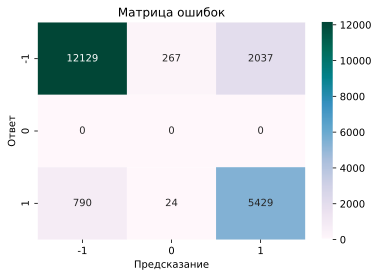

In [ ]:
import sklearn

Y_pr_en = Cls.predict(X_test)
acc = np.sum(Y_test == Y_pr_en)/len(Y_test)

from sklearn.metrics import confusion_matrix

M = sklearn.metrics.confusion_matrix(Y_test, Y_pr_en)
plt.title('Матрица ошибок')
sns.heatmap(M, cmap='PuBuGn', annot=True, fmt='d').set(xlabel='Предсказание', ylabel='Ответ', yticklabels=[-1, 0, 1], xticklabels=[-1, 0, 1])
plt.savefig("matr_sg.pdf", format="pdf", bbox_inches='tight')
# plt.axis('off')


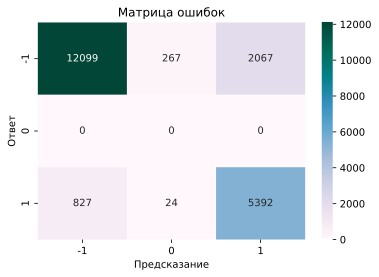

In [ ]:
import sklearn

Y_pr_en = Cl.predict(X_test)
acc = np.sum(Y_test == Y_pr_en)/len(Y_test)

from sklearn.metrics import confusion_matrix

M = sklearn.metrics.confusion_matrix(Y_test, Y_pr_en)
plt.title('Матрица ошибок')
sns.heatmap(M, cmap='PuBuGn', annot=True, fmt='d').set(xlabel='Предсказание', ylabel='Ответ', yticklabels=[-1, 0, 1], xticklabels=[-1, 0, 1])
plt.savefig("matr_g.pdf", format="pdf", bbox_inches='tight')
# plt.axis('off')


In [ ]:
Y_test

array([-1, -1, -1, ...,  1,  1,  1])

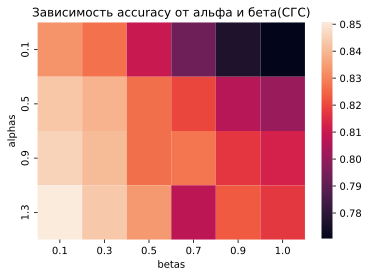

In [ ]:
temp = []
alp = []
bet = []
for i in range(0, 24):
    alp.append(alphas[i//6])
    bet.append(beta[i%6])
    temp.append(sgd_list_sum[i]['accuracy'][-1])
tmp = pd.DataFrame({'acc': temp, 'alp': alp, 'bet': bet})




tmp = tmp.loc[:, ['acc', 'alp', 'bet']].groupby(['alp', 'bet']).mean()
tmp = pd.pivot_table(data=tmp, index='alp', columns='bet', values='acc')

plt.title('Зависимость accuracy от альфа и бета(СГС)')
sns.heatmap(data=tmp).set(ylabel='alphas', xlabel='betas')
plt.savefig("sgdmatr.pdf", format="pdf", bbox_inches='tight')
# plt.axis('off')

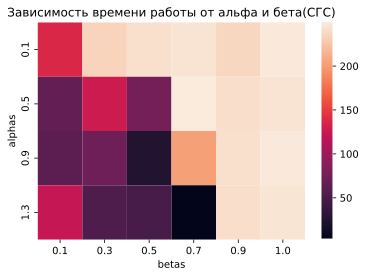

In [ ]:
temp = []
alp = []
bet = []
for i in range(0, 24):
    alp.append(alphas[i//6])
    bet.append(beta[i%6])
    temp.append(sgd_list_sum[i]['time'][-1])
tmp = pd.DataFrame({'acc': temp, 'alp': alp, 'bet': bet})




tmp = tmp.loc[:, ['acc', 'alp', 'bet']].groupby(['alp', 'bet']).mean()
tmp = pd.pivot_table(data=tmp, index='alp', columns='bet', values='acc')

plt.title('Зависимость времени работы от альфа и бета(СГС)')
sns.heatmap(data=tmp).set(ylabel='alphas', xlabel='betas')
plt.savefig("sgdmatrt.pdf", format="pdf", bbox_inches='tight')
# plt.axis('off')

In [ ]:
cl = ['r', 'y', 'g', 'c', 'b', 'm']
alp = [0.7, 0.7, 0.7, 0.7, 1]

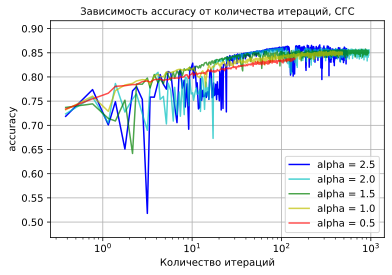

In [ ]:
mina = np.min(sgd_list[0]['accuracy'][1:])
maxa = np.max(sgd_list[0]['accuracy'][1:])
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list[i]['epoch_num'][1:], sgd_list[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
    mina = min(np.min(sgd_list[i]['accuracy'][1:]), mina)
    maxa = max(np.max(sgd_list[i]['accuracy'][1:]), maxa)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
plt.ylim(mina - 0.05, maxa + 0.05)
plt.title('Зависимость accuracy от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.savefig("asgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

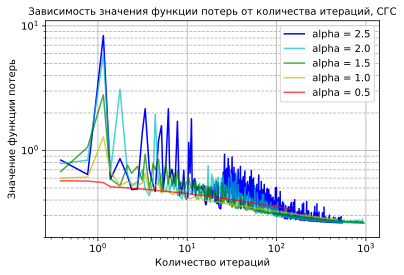

In [ ]:

for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list[i]['epoch_num'][1:], sgd_list[i]['func'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.2, 11)
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.yticks(range(-1, 10))
plt.title('Зависимость значения функции потерь от количества итераций, СГС', fontsize=10)
plt.grid(True, axis='y', which='both')
plt.grid(True, axis='y', which='minor', linestyle='--')
plt.grid(True, axis='x', which='major')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.savefig("asgdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

https://stackoverflow.com/questions/14530113/set-ticks-with-logarithmic-scale

https://www.tutorialspoint.com/how-to-show-minor-tick-labels-on-a-log-scale-with-matplotlib

https://newbedev.com/how-to-show-minor-tick-labels-on-log-scale-with-matplotlib

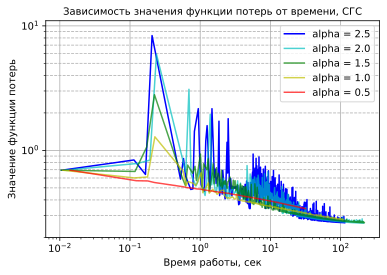

In [ ]:
mina = np.min(sgd_list[i]['func'])
maxa = np.max(sgd_list[i]['func'])
fig1, ax = plt.subplots()
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    ax.plot(sgd_list[i]['time'], sgd_list[i]['func'], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
    mina = min(np.min(sgd_list[i]['func']), mina)
    maxa = max(np.max(sgd_list[i]['func']), maxa)
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.2, 11)
#plt.yticks(range(-1, 10))
plt.grid(True, axis='y', which='both')
plt.grid(True, axis='y', which='minor', linestyle='--')
plt.grid(True, axis='x', which='major')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, СГС', fontsize=10)
plt.savefig("asgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

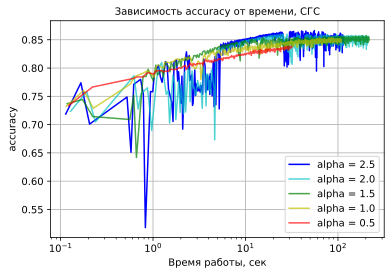

In [ ]:
mina = np.min(sgd_list[0]['accuracy'][1:])
maxa = np.max(sgd_list[0]['accuracy'][1:])
fig1, ax = plt.subplots()
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list[i]['accuracy'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    ax.plot(sgd_list[i]['time'][1:], sgd_list[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
    mina = min(np.min(sgd_list[i]['accuracy'][1:]), mina)
    maxa = max(np.max(sgd_list[i]['accuracy'][1:]), maxa)
#plt.xscale('log')
#plt.yscale('log')
#plt.yticks(range(-1, 10))
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от времени, СГС', fontsize=10)
plt.savefig("asgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

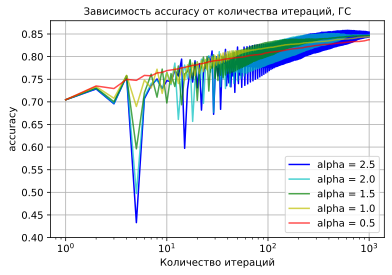

In [ ]:

for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
    #plt.plot(sgd_list[i]['epoch_num'][1:], sgd_list[i]['accuracy'][1:], color=((i%3)*0.3, (i)*0.1, (i)*0.1), label=['sgd=', (i+1)*0.5])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
plt.title('Зависимость accuracy от количества итераций, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.yticks([i*0.05 for i in range(8, 18)])
plt.xscale('log')
plt.savefig("agdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

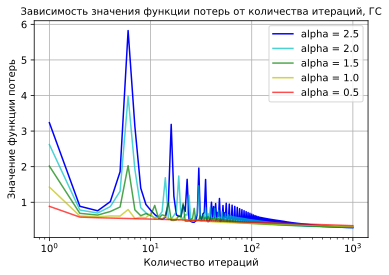

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list[i]['func'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от количества итераций, ГС', fontsize=10)
plt.grid(True)

plt.legend()
plt.savefig("agdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

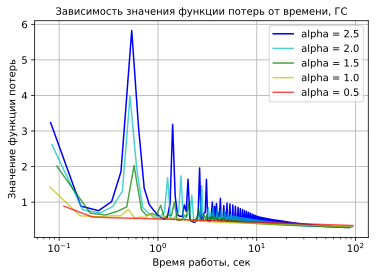

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list[i]['func'])), dtype=int)
    plt.plot(gd_list[i]['time'][1:], gd_list[i]['func'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("agdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

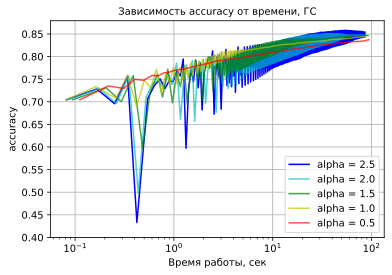

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list[i]['func'])), dtype=int)
    plt.plot(gd_list[i]['time'][1:], gd_list[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='alpha = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
plt.yticks([i*0.05 for i in range(8, 18)])
plt.title('Зависимость accuracy от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("agdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
import pickle
with open('datasgd_bs.pickle', 'wb') as f:
    pickle.dump(sgd_list_bs, f)
#with open('datagd.pickle', 'wb') as f:
    #pickle.dump(gd_list, f)

In [ ]:
import pickle
with open('datasgd_bs.pickle', 'rb') as f:
    sgd_list_bs = pickle.load(f)
with open('datagd (4).pickle', 'rb') as f:
    gd_list = pickle.load(f)

In [ ]:
sgd_list_b = []
gd_list_b = []
w_0 = np.zeros((X_tr.shape[1]))
for i in beta:
    print(i)
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=0.5, step_beta=i, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=0.5, step_beta=i, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    gd_list_b.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
    sgd_list_b.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2))

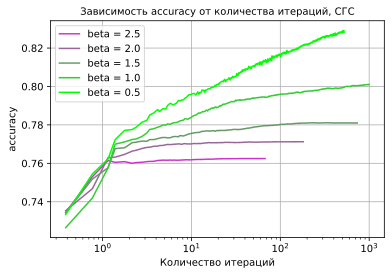

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_b[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_b[i]['epoch_num'][1:], sgd_list_b[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.savefig("bsgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

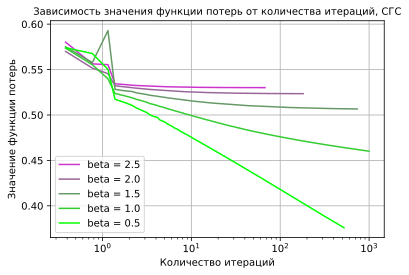

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_b[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_b[i]['epoch_num'][1:], sgd_list_b[i]['func'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("bsgdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

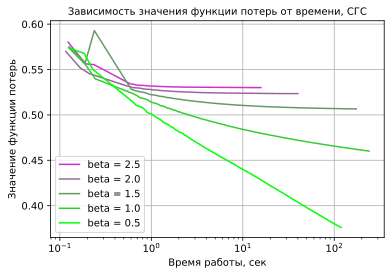

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_b[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_b[i]['time'][1:], sgd_list_b[i]['func'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("bsgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

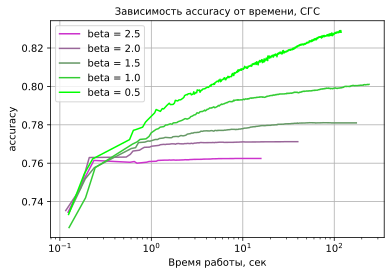

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_b[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_b[i]['time'][1:], sgd_list_b[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от времени, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("bsgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

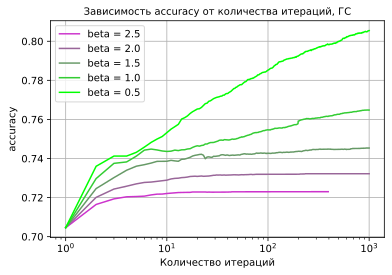

In [ ]:

for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_b[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list_b[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
    #plt.plot(sgd_list[i]['epoch_num'][1:], sgd_list[i]['accuracy'][1:], color=((i%3)*0.3, (i)*0.1, (i)*0.1), label=['sgd=', (i+1)*0.5])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от количества итераций, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("bgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

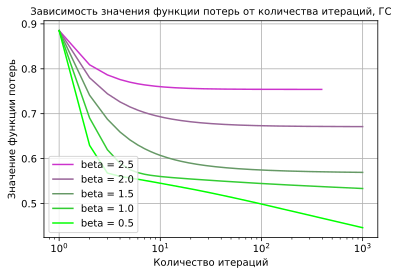

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_b[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list_b[i]['func'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от количества итераций, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("bgdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

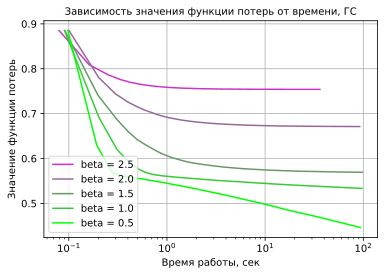

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_b[i]['time'])), dtype=int)
    plt.plot(gd_list_b[i]['time'][1:], gd_list_b[i]['func'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("bgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

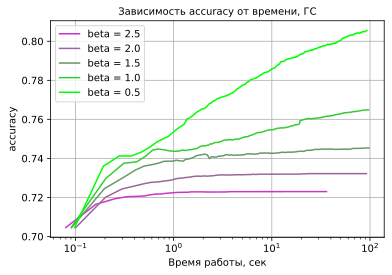

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_b[i]['func'])), dtype=int)
    plt.plot(gd_list_b[i]['time'][1:], gd_list_b[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, i*0.2), label='beta = ' + str((i+1)*0.5))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("bgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
sgd_list_w = []
gd_list_w = []
w_0 = np.zeros((X_tr.shape[1]))
weight = []
ls = X_tr.shape[1]
weight.append(np.zeros((ls)))
weight.append(np.array([round(random.choice([-0.5/ls, 0.5/ls]),5) for i in range(ls)]))
weight.append(np.full(ls, 1/ls))
weight.append(np.array([round(random.normalvariate(0, 0.3),5) for i in range(ls)]))
weight.append(np.ones((ls)))
for i in weight:
    print(i)
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=0.5, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=0.5, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    gd_list_w.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, i, trace=True))
    sgd_list_w.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, i, trace=True, log_freq=0.2))

[0. 0. 0. ... 0. 0. 0.]
[-0.00013 -0.00013  0.00013 ... -0.00013  0.00013  0.00013]
[0.00026767 0.00026767 0.00026767 ... 0.00026767 0.00026767 0.00026767]
[-0.21845  0.42031 -0.25336 ...  0.30119 -0.29898 -0.05031]
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
pl = [' = 0', ' = +(-)1/2N', ' = 1/N', ' from n.d', ' = 1']
cl = ['r', 'g', 'b', 'm', 'y']
al = [0.3, 0.5, 1, 1, 1]
lin = [3, 2, 1, 1, 1]

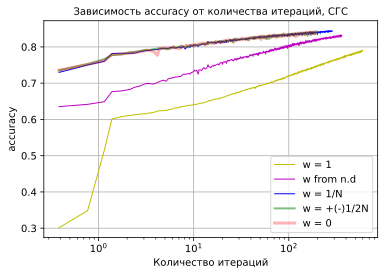

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_w[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_w[i]['epoch_num'][1:], sgd_list_w[i]['accuracy'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.savefig("wsgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

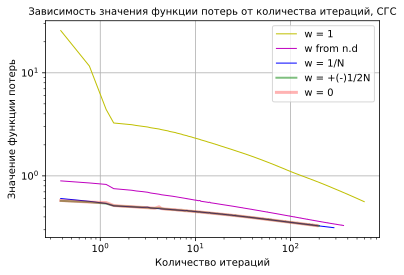

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_w[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_w[i]['epoch_num'][1:], sgd_list_w[i]['func'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("wsgdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

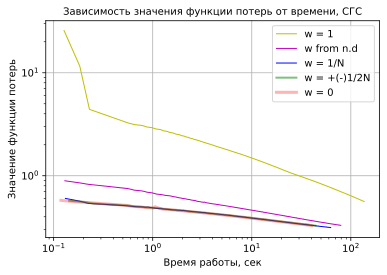

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_w[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_w[i]['time'][1:], sgd_list_w[i]['func'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("wsgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

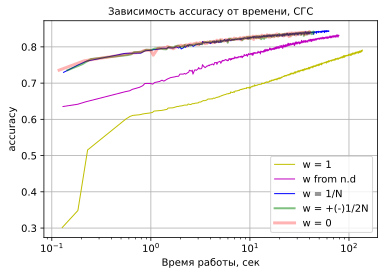

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(sgd_list_w[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_w[i]['time'][1:], sgd_list_w[i]['accuracy'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от времени, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("wsgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

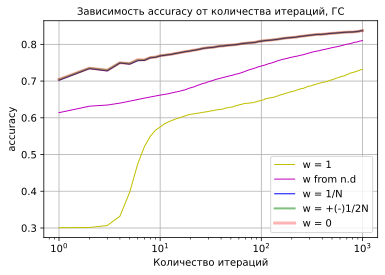

In [ ]:

for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_w[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list_w[i]['accuracy'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
    #plt.plot(sgd_list[i]['epoch_num'][1:], sgd_list[i]['accuracy'][1:], color=((i%3)*0.3, (i)*0.1, (i)*0.1), label=['sgd=', (i+1)*0.5])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от количества итераций, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("wgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

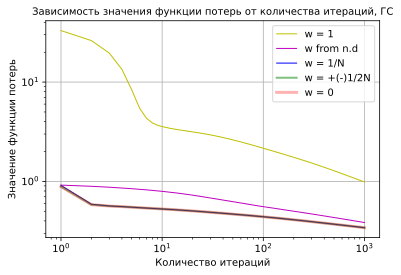

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_w[i]['func'])), dtype=int)
    plt.plot(x1[1:], gd_list_w[i]['func'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от количества итераций, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("wgdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

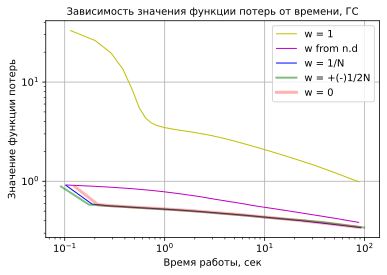

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_w[i]['time'])), dtype=int)
    plt.plot(gd_list_w[i]['time'][1:], gd_list_w[i]['func'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
#plt.xticks(range(2, 8))
plt.title('Зависимость значения функции потерь от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("wgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

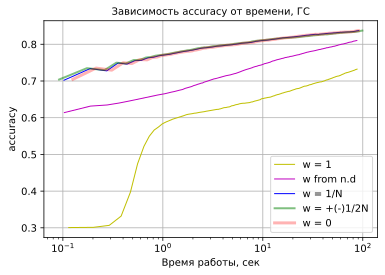

In [ ]:
for i in reversed(range(5)):
    x1 = np.array(np.arange(len(gd_list_w[i]['func'])), dtype=int)
    plt.plot(gd_list_w[i]['time'][1:], gd_list_w[i]['accuracy'][1:], color=cl[i], label='w' + pl[i], alpha=al[i], linewidth = lin[i])
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
#plt.xticks(range(2, 8))
plt.title('Зависимость accuracy от времени, ГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.savefig("wgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
sgd_list_bs = []
w_0 = np.zeros((X_tr.shape[1]))
bi = [(5*(i%2 + 1))**(i//2) for i in range(2, 11)]
for i in bi:
    print(int(i))
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=int(i), step_alpha=0.5, step_beta=0.5, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    sgd_list_bs.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2))

In [ ]:
cl = ['r', 'orange', 'y', 'lime', 'g', 'b', 'k', 'm', 'fuchsia', 'c'] 
alp = [0.8] * 10
pl = [7, 8, 5, 6, 4, 3]

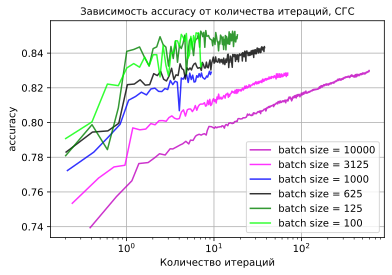

In [ ]:

for i in pl:
    x1 = np.array(np.arange(len(sgd_list_bs[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_bs[i]['epoch_num'][1:], sgd_list_bs[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='batch size = ' + str(bi[i]))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('accuracy')
plt.title('Зависимость accuracy от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend(loc="lower right")
plt.xscale("log")
plt.savefig("bisgdai.pdf", format="pdf", bbox_inches='tight')
plt.show()

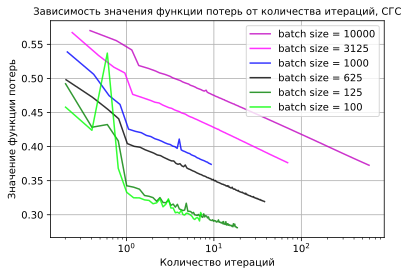

In [ ]:
for i in pl:
    x1 = np.array(np.arange(len(sgd_list_bs[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_bs[i]['epoch_num'][1:], sgd_list_bs[i]['func'][1:], color=cl[i], alpha = alp[i], label='batch size = ' + str(int(bi[i])))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Количество итераций')
plt.ylabel('Значение функции потерь')
plt.xticks(bi)
plt.title('Зависимость значения функции потерь от количества итераций, СГС', fontsize=10)
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.savefig("bigdfi.pdf", format="pdf", bbox_inches='tight')
plt.show()

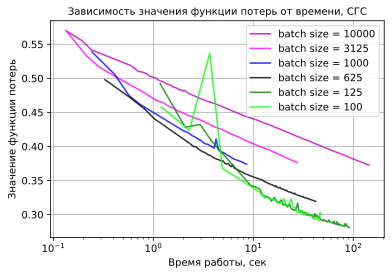

In [ ]:
for i in pl:
    x1 = np.array(np.arange(len(sgd_list_bs[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_bs[i]['time'][1:], sgd_list_bs[i]['func'][1:], color=cl[i], alpha = alp[i], label='batch size = ' + str(int(bi[i])))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('Значение функции потерь')
plt.title('Зависимость значения функции потерь от времени, СГС', fontsize=10)
plt.grid(True)
plt.xscale('log')
plt.legend(loc="upper right")
#plt.xscale('log')
plt.savefig("bisgdft.pdf", format="pdf", bbox_inches='tight')
plt.show()

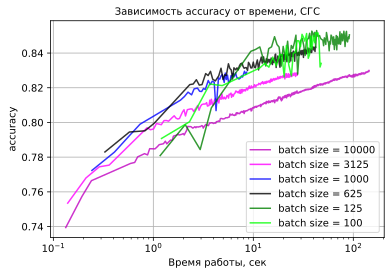

In [ ]:
for i in pl:
    x1 = np.array(np.arange(len(sgd_list_bs[i]['func'])), dtype=int)
    #plt.plot(x1[1:], gd_list[i]['accuracy'][1:], color=(i*0.2, (5-i)*0.2, 0), label=['gd=', (i+1)*0.5])
    plt.plot(sgd_list_bs[i]['time'][1:], sgd_list_bs[i]['accuracy'][1:], color=cl[i], alpha = alp[i], label='batch size = ' + str(int(bi[i])))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Время работы, сек')
plt.ylabel('accuracy')
plt.title('Зависимость accuracy от времени, СГС', fontsize=10)
plt.grid(True)
plt.xscale('log')
plt.legend()
plt.savefig("bisgdat.pdf", format="pdf", bbox_inches='tight')
plt.show()

Эксп 6

In [58]:
#Лемматизатор и определитель части речи взять с семинара

d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

sw = set(stopwords.words('english'))

def get_wordnet_post(tr_tag):
    my_switch = {'J':wordnet.wordnet.ADJ, 'V':wordnet.wordnet.VERB, 'N':wordnet.wordnet.NOUN, 'R':wordnet.wordnet.ADV}
    for key, item in my_switch.items():
        if tr_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN


def slem(sentn):
    lm = WordNetLemmatizer()
    token_s = sentn.split()
    token_s = [word for word in token_s if word not in sw]
    pos_tag = [(word, get_wordnet_post(tag)) for word, tag in nltk.pos_tag(token_s)]
    return ' '.join([lm.lemmatize(word, tag) for word, tag in pos_tag])

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: slem(x))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: slem(x))

In [60]:
vectorizer = CountVectorizer(min_df=1e-5, max_df=0.2) #Обратить внимание на параметр
X_tr_l = vectorizer.fit_transform(p_tr)
X_test_l = vectorizer.transform(p_test)

In [59]:
Y_tr

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
sgd_lst = []
gd_lst = []
sgd_lem = []
gd_lem = []
w_0 = np.zeros((X_tr.shape[1]))
for i in range(2, 4):
    for j in range(0, 3):
        print(i, alphas[i], beta[j])
        w_0 = np.zeros((X_tr.shape[1]))
        Cls = SGDClassifier(loss_function='binary_logistic', batch_size=10000, step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        Cl = GDClassifier(loss_function='binary_logistic', step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        gd_lst.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
        sgd_lst.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.2))
        w_0 = np.zeros((X_tr_l.shape[1]))
        gd_lem.append(Cl.fit(X_tr_l, Y_tr, X_test_l, Y_test, w_0, trace=True))
        sgd_lem.append(Cls.fit(X_tr_l, Y_tr, X_test_l, Y_test, w_0, trace=True, log_freq=0.2))

2 0.9 0.1
2 0.9 0.3
2 0.9 0.5
3 1.3 0.1
3 1.3 0.3
3 1.3 0.5


In [ ]:
for i in range(0, 6):
    print(gd_lst[i]['accuracy'][-1], 'gd no lem')
    print(sgd_lst[i]['accuracy'][-1], 'sgd no lem')
    print(sgd_lem[i]['accuracy'][-1], 'sgd lem')
    print(gd_lem[i]['accuracy'][-1], 'gd lem')

0.843199845231186 gd no lem
0.8474076223640936 sgd no lem
0.8504546333913716 sgd lem
0.845666473205649 gd lem
0.830624879086864 gd no lem
0.8368156316502224 sgd no lem
0.8485683884697234 sgd lem
0.8402979299671116 gd lem
0.8167924163281098 gd no lem
0.8347842909653704 sgd no lem
0.8442638808280132 sgd lem
0.8321242019733024 gd lem
0.8459566647320564 gd no lem
0.8514703037337976 sgd no lem
0.8507931901721804 sgd lem
0.8485683884697234 gd lem
0.8339137163861482 gd no lem
0.8426678274327722 sgd no lem
0.8491971367769394 sgd lem
0.8424260011607662 gd lem
0.8220642290578448 gd no lem
0.833478429096537 sgd no lem
0.8459566647320564 sgd lem
0.8352679435093828 gd lem


In [ ]:
for i in range(0, 6):
    print(gd_lst[i]['time'][-1], 'gd no lem')
    print(sgd_lst[i]['time'][-1], 'sgd no lem')
    print(sgd_lem[i]['time'][-1], 'sgd lem')
    print(gd_lem[i]['time'][-1], 'gd lem')

99.25043380803254 gd no lem
95.23220754005888 sgd no lem
90.37134975802473 sgd lem
61.50988872801827 gd lem
97.02047585307082 gd no lem
36.18312825900648 sgd no lem
124.06920308495683 sgd lem
62.16844913499517 gd lem
96.18170189402372 gd no lem
111.22443231995203 sgd no lem
175.90477167289646 sgd lem
63.33244865699453 gd lem
98.24868903103925 gd no lem
114.08774675100358 sgd no lem
66.39676252107529 sgd lem
62.93118151598537 gd lem
95.2868098520521 gd no lem
50.00913442898309 sgd no lem
138.60415771089902 sgd lem
59.62632728295648 gd lem
94.53486530304144 gd no lem
41.38902973301447 sgd no lem
177.642439130188 sgd lem
64.97326668698952 gd lem


In [ ]:
X_tr.shape[1]

3736

In [ ]:
X_tr_l.shape[1]

3043

In [ ]:
print(gd_cross_val_score(X_tr, Y_tr, 1.3, 0.1))

0.8355178455589733


In [ ]:
print(gd_cross_val_score(X_tr_l, Y_tr, 1.3, 0.1))

0.8355753097693963


In [ ]:
print(sgd_cross_val_score(X_tr_l, Y_tr, 1.3, 0.1))

0.8448148718541023


In [ ]:
print(sgd_cross_val_score(X_tr, Y_tr, 1.3, 0.1))

0.837169656861104


In [ ]:
import pickle
with open('datasgd_lst.pickle', 'wb') as f:
    pickle.dump(sgd_lst, f)
with open('datagd_lst.pickle', 'wb') as f:
    pickle.dump(gd_lst, f)
with open('datasgd_lem.pickle', 'wb') as f:
    pickle.dump(sgd_lem, f)
with open('datagd_lem', 'wb') as f:
    pickle.dump(gd_lem, f)

In [ ]:
def gd_cross_val_score(X, Y, a, b, cv=None, **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 3)
    c = 0
    d = np.zeros(len(cv))
    for j in cv:
        w_0 = np.zeros((X.shape[1]))
        Cl = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=b, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        d[c] = Cl.fit(X[j[0]], Y[j[0]], X[j[1]], Y[j[1]], w_0, trace=True)['accuracy'][-1]
        c += 1
    return d.mean()

In [ ]:
def sgd_cross_val_score(X, Y, a, b, cv=None, **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 3)
    c = 0
    d = np.zeros(len(cv))
    for j in cv:
        w_0 = np.zeros((X.shape[1]))
        Cl = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=b, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        d[c] = Cl.fit(X[j[0]], Y[j[0]], X[j[1]], Y[j[1]], w_0, trace=True, log_freq=0.33)['accuracy'][-1]
        c += 1
    return d.mean()

In [ ]:
def kfold(n, n_folds):
    z = n % n_folds
    s = 1
    k = n//n_folds
    k1 = 0
    r = []
    for x in range(n_folds):
        if z <= 0:
            s = 0
        l1 = list(range(k1, k1 + s + k))
        l2 = list(range(0, k1))
        l2 = l2 + (list(range(k1 + s + k, n)))
        r.append((np.array(l2), np.array(l1)))
        z -= 1
        k1 += s + k
    return r

Эксперимент 7

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(min_df=0.001)

d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

X_tr_tf = tfid.fit_transform(d_tr['comment_text'])
X_test_tf = tfid.transform(d_test['comment_text'])

In [ ]:
X_tr_tf.shape[1]

3736

In [ ]:
print(gd_cross_val_score(X_tr_tf, Y_tr, 1.3, 0.1))
print(sgd_cross_val_score(X_tr_tf, Y_tr, 1.3, 0.1))

0.7265258988213307
0.8030348045519394


In [ ]:
sgd_tf = []
gd_tf = []
for i in range(2, 4):
    for j in range(0, 3):
        print(i, alphas[i], beta[j])
        Cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        Cl = GDClassifier(loss_function='binary_logistic', step_alpha=alphas[i], step_beta=beta[j], tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
        w_0 = np.zeros((X_tr_tf.shape[1]))
        gd_tf.append(Cl.fit(X_tr_tf, Y_tr, X_test_tf, Y_test, w_0, trace=True))
        sgd_tf.append(Cls.fit(X_tr_tf, Y_tr, X_test_tf, Y_test, w_0, trace=True, log_freq=0.33))

2 0.9 0.1
2 0.9 0.3
2 0.9 0.5
3 1.3 0.1
3 1.3 0.3
3 1.3 0.5


In [ ]:
for i in range(0, 6):
    print(gd_lst[i]['time'][-1], 'gd no lem')
    print(sgd_lst[i]['time'][-1], 'sgd no lem')
    print(sgd_tf[i]['time'][-1], 'sgd lem')
    print(gd_tf[i]['time'][-1], 'gd lem')

99.25043380803254 gd no lem
95.23220754005888 sgd no lem
102.77280033714487 sgd lem
85.12408633689483 gd lem
97.02047585307082 gd no lem
36.18312825900648 sgd no lem
191.034487052013 sgd lem
90.09111891194334 gd lem
96.18170189402372 gd no lem
111.22443231995203 sgd no lem
308.7827357178612 sgd lem
83.97045086103753 gd lem
98.24868903103925 gd no lem
114.08774675100358 sgd no lem
49.89460609102389 sgd lem
83.97653313704359 gd lem
95.2868098520521 gd no lem
50.00913442898309 sgd no lem
122.13252979696699 sgd lem
81.98975682002492 gd lem
94.53486530304144 gd no lem
41.38902973301447 sgd no lem
354.78686266299337 sgd lem
84.3856559480555 gd lem


In [ ]:
for i in range(0, 6):
    print(gd_lst[i]['accuracy'][-1], 'gd no lem')
    print(sgd_lst[i]['accuracy'][-1], 'sgd no lem')
    print(sgd_tf[i]['accuracy'][-1], 'sgd lem')
    print(gd_tf[i]['accuracy'][-1], 'gd lem')

0.843199845231186 gd no lem
0.8474076223640936 sgd no lem
0.8485683884697234 sgd lem
0.805233120526214 gd lem
0.830624879086864 gd no lem
0.8368156316502224 sgd no lem
0.843635132520797 sgd lem
0.7662990907332172 gd lem
0.8167924163281098 gd no lem
0.8347842909653704 sgd no lem
0.835074482491778 sgd lem
0.736796285548462 gd lem
0.8459566647320564 gd no lem
0.8514703037337976 sgd no lem
0.8441187850648094 sgd lem
0.8135035790288256 gd lem
0.8339137163861482 gd no lem
0.8426678274327722 sgd no lem
0.8439253240472044 sgd lem
0.7794060746759528 gd lem
0.8220642290578448 gd no lem
0.833478429096537 sgd no lem
0.8411201392919326 sgd lem
0.7456471271038886 gd lem


In [ ]:
import pickle
with open('datasgd_tf.pickle', 'wb') as f:
    pickle.dump(sgd_tf, f)
with open('datagd_tf', 'wb') as f:
    pickle.dump(gd_tf, f)

In [ ]:
d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

vectorizer = CountVectorizer(min_df=0.001) #Обратить внимание на параметр
X_tr = vectorizer.fit_transform(d_tr['comment_text'])
X_test = vectorizer.transform(d_test['comment_text'])

In [54]:

sgd_max = []
gd_max = []
min = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
max = [0.2, 0.15, 0.1, 0.05, 0.01]
for i in range(0, 5):
    print(min[i])
    vectorizer = CountVectorizer(min_df=min[i]) #Обратить внимание на параметр
    X_tr = vectorizer.fit_transform(d_tr['comment_text'])
    X_test = vectorizer.transform(d_test['comment_text'])
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    w_0 = np.zeros((X_tr.shape[1]))
    gd_min.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
    sgd_min.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.33))
    print(max[i])
    vectorizer = CountVectorizer(max_df=max[i]) #Обратить внимание на параметр
    X_tr = vectorizer.fit_transform(d_tr['comment_text'])
    X_test = vectorizer.transform(d_test['comment_text'])
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    w_0 = np.zeros((X_tr.shape[1]))
    gd_max.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
    sgd_max.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.33))

0.2
0.15
0.1
0.05
0.01


In [92]:

sgd_min = []
gd_min = []
min = [1e-2, 1e-1]
for i in range(0, 5):
    print(min[i])
    vectorizer = CountVectorizer(min_df=min[i]) #Обратить внимание на параметр
    X_tr = vectorizer.fit_transform(d_tr['comment_text'])
    X_test = vectorizer.transform(d_test['comment_text'])
    Cls = SGDClassifier(loss_function='binary_logistic', batch_size=20, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    Cl = GDClassifier(loss_function='binary_logistic', step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
    w_0 = np.zeros((X_tr.shape[1]))
    gd_min.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
    sgd_min.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.33))

0.01
0.1


IndexError: ignored

In [93]:

sgd_max = []
gd_max = []
min = [1e-2, 1e-1]
vectorizer = CountVectorizer(max_df=1) #Обратить внимание на параметр
X_tr = vectorizer.fit_transform(d_tr['comment_text'])
X_test = vectorizer.transform(d_test['comment_text'])
Cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
Cl = GDClassifier(loss_function='binary_logistic', step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
w_0 = np.zeros((X_tr.shape[1]))
gd_max.append(Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True))
sgd_max.append(Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.33))

In [ ]:
print(sgd_min[-1]['accuracy'][-1]) #1e-1
print(sgd_min[-1]['time'][-1])
print(sgd_min[-2]['accuracy'][-1])
print(sgd_min[-2]['time'][-1])
print(sgd_max[-1]['accuracy'][-1])
print(sgd_max[-1]['time'][-1])

In [64]:
vectorizer = CountVectorizer()
X_tr = vectorizer.fit_transform(d_tr['comment_text'])
X_test = vectorizer.transform(d_test['comment_text'])
Cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
Cl = GDClassifier(loss_function='binary_logistic', step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
w_0 = np.zeros((X_tr.shape[1]))
hist0 = Cl.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True)
histg0 = Cls.fit(X_tr, Y_tr, X_test, Y_test, w_0, trace=True, log_freq=0.33)

In [65]:
print(hist0['time'][-1])
print(hist0['accuracy'][-1])
print(histg0['time'][-1])
print(histg0['accuracy'][-1])

128.3832166379616
0.8528728961114336
303.1318545839895
0.8615786419036564


In [66]:
X_tr.shape[1]

89368

In [67]:
vectorizer = CountVectorizer() #Обратить внимание на параметр
X_tr_l = vectorizer.fit_transform(p_tr)
X_test_l = vectorizer.transform(p_test)

In [61]:
p_tr = d_tr['comment_text']
p_test = d_test['comment_text']

In [52]:

min = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
max = [0.2, 0.15, 0.1, 0.05, 0.01]
for i in range(0, 5):
    print(min[i])
    vectorizer = CountVectorizer(min_df=min[i]) #Обратить внимание на параметр
    X_tr = vectorizer.fit_transform(d_tr['comment_text'])
    X_test = vectorizer.transform(d_test['comment_text'])
    print(X_tr.shape[1])
    print(max[i])
    vectorizer = CountVectorizer(max_df=max[i]) #Обратить внимание на параметр
    X_tr = vectorizer.fit_transform(d_tr['comment_text'])
    X_test = vectorizer.transform(d_test['comment_text'])
    print(X_tr.shape[1])

1e-05
89368
0.2
89348
0.0001
16050
0.15
89331
0.001
3736
0.1
89313
0.01
568
0.05
89260
0.1
55
0.01
88800


In [ ]:
import pickle
with open('datasgd_max.pickle', 'wb') as f:
    pickle.dump(sgd_max, f)
with open('datasgd_min', 'wb') as f:
    pickle.dump(sgd_min, f)

with open('datagd_max.pickle', 'wb') as f:
    pickle.dump(gd_max, f)
with open('datagd_min', 'wb') as f:
    pickle.dump(gd_min, f)

In [56]:
for i in range(0, 5):
    print(min[i])
    #print(gd_min[i]['accuracy'][-1], 'gd min')
    #print(sgd_min[i]['accuracy'][-1], 'sgd min')
    print(max[i])
    print(gd_max[i]['accuracy'][-1], 'gd max')
    print(sgd_max[i]['accuracy'][-1], 'sgd max')

1e-05
0.2
0.8536951054362546 gd max
0.85703230798994 sgd max
0.0001
0.15
0.8550976978138906 gd max
0.8558715418843104 sgd max
0.001
0.1
0.8544205842522732 gd max
0.856838846972335 sgd max
0.01
0.05
0.8554362545946992 gd max
0.8580963435867672 sgd max
0.1
0.01
0.7949313213387502 gd max
0.791642484039466 sgd max


In [57]:
for i in range(0, 5):
    print(min[i])
    #print(gd_list_min[i]['time'][-1], 'gd min')
    #print(sgd_list_min[i]['time'][-1], 'sgd min')
    print(max[i])
    print(gd_list_max[i]['time'][-1], 'gd max')
    print(sgd_list_max[i]['time'][-1], 'sgd max')

1e-05
0.2
123.80293468499963 gd max
171.01660245100095 sgd max
0.0001
0.15
123.76626451900029 gd max
190.0580226360014 sgd max
0.001
0.1
123.53807696000035 gd max
128.55471935399942 sgd max
0.01
0.05
124.07965973700038 gd max
271.39917263200596 sgd max
0.1
0.01
124.08478248599795 gd max
471.38574768999433 sgd max


In [ ]:
#Лемматизатор и определитель части речи взять с семинара

d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

sw = set(stopwords.words('english'))

def get_wordnet_post(tr_tag):
    my_switch = {'J':wordnet.wordnet.ADJ, 'V':wordnet.wordnet.VERB, 'N':wordnet.wordnet.NOUN, 'R':wordnet.wordnet.ADV}
    for key, item in my_switch.items():
        if tr_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN


def slem(sentn):
    lm = WordNetLemmatizer()
    token_s = sentn.split()
    token_s = [word for word in token_s if word not in sw]
    pos_tag = [(word, get_wordnet_post(tag)) for word, tag in nltk.pos_tag(token_s)]
    return ' '.join([lm.lemmatize(word, tag) for word, tag in pos_tag])

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: slem(x))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: slem(x))

In [ ]:
d_tr = pd.read_csv('toxic_train.csv')
d_test = pd.read_csv('toxic_test.csv')

d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: x.lower())
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_tr['comment_text'] = d_tr['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

d_test['comment_text'] = d_test['comment_text'].apply(lambda x: x.lower())
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('\n', ' ', str(x), count=0)))
d_test['comment_text'] = d_test['comment_text'].apply(lambda x: str(re.sub('[^0-9a-zA-Z]', ' ', str(x), count=0)))

In [82]:
d_tr_en = pd.read_csv('toxic_train.csv')
d_test_en = pd.read_csv('toxic_test.csv')

In [77]:
vectorizer = CountVectorizer(min_df=1e-5) #Обратить внимание на параметр
X_tr_l = vectorizer.fit_transform(p_tr)
X_test_l = vectorizer.transform(p_test)

In [79]:
Cls = SGDClassifier(loss_function='binary_logistic', batch_size=125, step_alpha=1.3, step_beta=0.1, tolerance=1e-7, max_iter=1000, l2_coef=0.0001)
w_0 = np.full(X_tr_l.shape[1], 1/X_tr_l.shape[1])
hist = Cls.fit(X_tr_l, Y_tr, X_test_l, Y_test, w_0, trace=True, log_freq=0.33)

In [71]:
np.unique(Y_pr_en)

array([-1.,  0.,  1.])

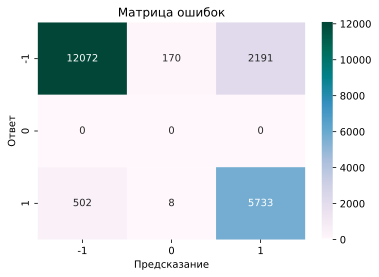

In [80]:
import sklearn

Y_pr_en = Cls.predict(X_test_l)
acc = np.sum(Y_test == Y_pr_en)/len(Y_test)

from sklearn.metrics import confusion_matrix

M = sklearn.metrics.confusion_matrix(Y_test, Y_pr_en)
plt.title('Матрица ошибок')
sns.heatmap(M, cmap='PuBuGn', annot=True, fmt='d').set(xlabel='Предсказание', ylabel='Ответ', yticklabels=[-1, 0, 1], xticklabels=[-1, 0, 1])
plt.savefig("matr_en.pdf", format="pdf", bbox_inches='tight')
# plt.axis('off')



In [81]:
print(acc)

0.8611433546140452


In [88]:
vl = ['not toxic', ' ', 'toxic']
k = 0
for i in range(1500, 20000):
    if (Y_pr_en[i] == -1) and (Y_test[i] == 1):
        print('До предобработки: ', d_test_en['comment_text'][i])
        print('После предобработки: ', d_test['comment_text'][i])
        s = 'True: ' + vl[int(Y_test[i] + 1)] + ' Predicted: ' + vl[int(Y_pr_en[i] + 1)] + '\n\n'
        print(s)
        if k < 3:
            k += 1
        else:
            break

vl = ['not toxic', ' ', 'toxic']
k = 0
for i in range(1500, 20000):
    if (Y_pr_en[i] == 1) and (Y_test[i] == -1):
        print('До предобработки: ', d_test_en['comment_text'][i])
        print('После предобработки: ', d_test['comment_text'][i])
        s = 'True: ' + vl[int(Y_test[i] + 1)] + ' Predicted: ' + vl[int(Y_pr_en[i] + 1)] + '\n\n'
        print(s)
        if k < 3:
            k += 1
        else:
            break

k = 0
for i in range(1500, 10000):
    if (Y_pr_en[i] == 0):
        print('До предобработки: ', d_test_en['comment_text'][i])
        print('После предобработки: ', d_test['comment_text'][i])
        s = 'True: ' + vl[int(Y_test[i] + 1)] + ' Predicted: ' + vl[int(Y_pr_en[i] + 1)] + '\n\n'
        print(s)
        if k < 4:
            k += 1
        else:
            break

До предобработки:  U wot? U wot? U wot? U wot? U wot? U wot? U wot? U wot? I reverted it myself. No need to be such a douchebag.
После предобработки:  u wot  u wot  u wot  u wot  u wot  u wot  u wot  u wot  i reverted it myself  no need to be such a douchebag 
True: toxic Predicted: not toxic


До предобработки:  ::::::: @Gob Lofa - I see your point but the experience of few indidual accounts - around 2 or 3 - does not support the claim that 'many' of the 40-50k UDR members were sectarian. One of the references you added claimed the UDR was 'full' of loyalist paramilitaries. That's a claim which you have made clear above you do not support, and it is a ridiculous claim.
После предобработки:           gob lofa   i see your point but the experience of few indidual accounts   around 2 or 3   does not support the claim that  many  of the 40 50k udr members were sectarian  one of the references you added claimed the udr was  full  of loyalist paramilitaries  that s a claim which you have ma

In [ ]:
d_tr_en = pd.read_csv('toxic_train.csv')
d_test_en = pd.read_csv('toxic_test.csv')

https://www.nltk.org/_modules/nltk/stem/wordnet.html

https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

https://coderoad.ru/5486337/%D0%9A%D0%B0%D0%BA-%D1%83%D0%B4%D0%B0%D0%BB%D0%B8%D1%82%D1%8C-%D1%81%D1%82%D0%BE%D0%BF-%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-%D1%81-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E-nltk-%D0%B8%D0%BB%D0%B8-python